<a id="TOP"></a>
<img src="https://upload.wikimedia.org/wikipedia/commons/6/60/NISAR_artist_concept.jpg" width=150/><img src="https://upload.wikimedia.org/wikipedia/commons/9/9b/NISAR_Mission_Logo.png" width=200/> 

***

# NASA ISRO Synthetic Aperture Radar Mission
## Combined Algorithm Theoretical Basis Document and Jupyter Notebook for <br> *Active Crop Area*

Authors: Jessica Martinez, Alex Christensen, Paul Siqueira <br>
Microwave Remote Sensing Laboratory <br>
University of Massachusetts -- Amherst <br>
Date: 2025-02-11 <br>
Last updated: 2025-August <br>

### Summary
This notebook describes the ATBD for generating an agricultural crop area product from NISAR time series data stacks. The algorithm is designed to meet the Level 2 Science requirements for detecting active crop area. This notebook constitutes a combination of formulating the theoretical basis for the NISAR active crop area algorithm that is based on the coefficient of variation and an implementation of the algorithm in executable python code.

This particular notebook contains two parts that are combined into one notebook.  These are
<ol>
    <li>The Coefficient of Variation (CV) Python code, and</li>
    <li>The USDA Cropland Data Layer (CDL)</li>
</ol>
Although not required to implement the NISAR Active Crop Area algorithm, the CDL is provided here to give an example how external data about the location of active crops can be used to optimally determine the threshold that can be applied to the CV for determining active crop area, and also used as a means for evaluating the algorithm.  For regions outside of the US (for example) where the CDL is not available, a similar landcover classification could be used, or one created from available optical data. <br>


<br>The NISAR requirement for Active Crop Area is: <br>

> *Requirement (L2-SCI-679):* <br> After the first year of operation, the NISAR Project shall measure crop area at 1-hectare resolution every 3 months with a classification accuracy of 80%.

### Overview of the Coefficient of Variation
Python code to implement coefficient of variation for crop/non-crop classification using a time series stack of SAR images. The notebook statistically calculates the CV across the time series stack and pixels in the resulting CV output are classified as “crop” or “non-crop” based on a threshold provided, or specified by the user. Pixels classified as water using a watermask derived from radar cross-section (RCS) values are removed prior to classification, due to the inherent variability of radar returns from water surfaces that make them inconsistent with the coefficient of variation (CV) patterns of non-cropland covers and prone to misclassification.

This notebook supports either the use of the USDA Cropland Data Layer (CDL) (which has been provided in the repository for use in this notebook) or external sources of labeled crop/non crop polygons which can be generated using high-resolution optical imagery of field-based methods such as windshield surveying. The labeled crop/non-crop validation data are used to calibrate and assess the classification threshold to improve classification results. The accuracy of the classification is evaluated against this data, and the results are exported as a Geotiff. 



Coefficient of Variation is calculated by: Standard Deviation/Mean


Datasets needed:

    Timeseries of SAR imagery
    
    CDL available at https://nassgeodata.gmu.edu/CropScape/

### Use conda environment:
`NISAR_L3_CropArea`

<a id="SEC_0.2"></a>
###  &emsp; Data Flow Diagram 
![NISAR_ATBD_crops_dataflow.png](NISAR_ATBD_crops_dataflow.png)

# 0 &emsp; Project Setup <a class="anchor" id="first"></a>

## 0.1  &emsp; Import packages

In [1]:
import numpy as np
import glob
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from osgeo import gdal, osr, ogr
import subprocess
import os
import re
import time
import scipy
import pandas as pd
import sys
from pandas import DataFrame
from IPython.display import Image
import sklearn  # imported from scikit-learn
from sklearn import metrics
from matplotlib.pyplot import figure
from matplotlib.colors import ListedColormap
from ipywidgets import interactive
from rasterio.plot import show_hist
from rasterio.enums import ColorInterp
from rasterio.enums import Resampling
import datetime
from datetime import date
from datetime import datetime, UTC
import math
os.environ['GDAL_DATA'] = os.popen('gdal-config --datadir').read().rstrip() # resolves gdal directory value error
 
from pathlib import Path
import io
import boto3
import rasterio
import zipfile
import h5py
from pyproj import CRS
import geopandas as gpd
import copy
import asf_search as asf
import earthaccess 
import json
from getpass import getpass
import requests
import s3fs

from IPython.display import display, HTML
from tqdm.notebook import tqdm
gdal.UseExceptions()


## 0.2  &emsp; Choose AOI and working directory 

In [2]:
main_dir = Path(os.path.dirname(os.getcwd()))
print(main_dir)

/home/jovyan/NISAR_CropArea


This notebook and it's repository have been set up to provide user's with data and classification parameters for Tifton, GA. With "demo" set as "True", this notebook can be fully self-contained and run completley through. 

In [3]:
demo = True
if demo:
    aoi = 'tifton'
    which_pol = 'HHHH'
else:
    aoi = input('What site?')
    which_pol = input('What polarization? [HHHH or HVHV]')
    box_left, box_top, box_right, box_bottom = [input('Define AOI West boundary?: '),
                                                input('Define AOI North boundary?: '),
                                                input('Define AOI East boundary?: '),
                                                input('Define AOI South boundary?: ')]


In [4]:
ancillary_dir = main_dir / 'ancillary_data'
aoi_dir = main_dir / aoi 
crop_dir = aoi_dir / 'crops'
GCOV_dir = aoi_dir / 'GCOV'
TMP_dir = aoi_dir / 'TMP'

Path(ancillary_dir).mkdir(parents = True, exist_ok = True)
Path(aoi_dir).mkdir(parents = True, exist_ok= True)
Path(crop_dir).mkdir(parents = True, exist_ok = True)
Path(GCOV_dir).mkdir(parents = True, exist_ok = True)
Path(TMP_dir).mkdir(parents = True, exist_ok = True)

print(aoi_dir)
print(crop_dir)

/home/jovyan/NISAR_CropArea/tifton
/home/jovyan/NISAR_CropArea/tifton/crops



# 1 &emsp; Get Data 

<a id="SEC_1.1"></a>
## 1.1  &emsp; Get GCOV Data

A pre-launch stack of sample GCOV products are provided for Tifton, GA.

Post-launch NISAR GCOV products will be available through ASF DAAC


In [5]:
if demo:
    gcov_url = ('s3://nisar-public-ebd/ATBD/ecosystems/croparea/sites/%s/*/*/*' %(aoi))
    s3 = s3fs.S3FileSystem(anon=True,endpoint_url='https://s3.us-west-1.wasabisys.com')
    all_GCOV_data = ['s3://' + k  for k in s3.glob(gcov_url)]

else:
    auth = earthaccess.login()
    s3cred = auth.get_s3_credentials(endpoint="https://nisar.asf.earthdatacloud.nasa.gov/s3credentials")
    results = earthaccess.search_data(short_name = 'NISAR_L2_GCOV_BETA_V1', 
                                        # temporal = ('2023-07-01 00:00:00', '2023-08-31 23:59:59'), # can also specify by time
                                        # granule_name = '*T00888*', # here we filter by files with CRID value of *T00888*
                                        bounding_box = (box_left, box_top, box_right, box_bottom )
                                       )
    ## Get URLS for search results
    all_GCOV_data = [earthaccess.results.DataGranule.data_links(x, access ='direct')[0] for x in results if earthaccess.results.DataGranule.data_links(x, access ='direct')[0].endswith('.h5')]

    s3 = s3fs.S3FileSystem(anon = False, key=s3cred['accessKeyId'], 
                           secret = s3cred['secretAccessKey'],
                           token = s3cred['sessionToken'],
                           client_kwargs ={'region_name': 'us-west-2'})
all_GCOV_data = sorted(all_GCOV_data)
print("number of available scenes:", len(all_GCOV_data))

number of available scenes: 10


In [6]:
# all_GCOV_data_links = glob.glob(str(aoi_dir/'ATBD_CROPS*-urls.txt'))[0]
# with open(all_GCOV_data_links, "r") as f:
#     all_GCOV_data = [line.strip() for line in f if line.strip() and '.h5' in line]
#     print("number of avaliable_scenes:", len(all_GCOV_data))
#     for i in range(len(all_GCOV_data)):
#         print(i, all_GCOV_data[i].split('/')[-1])

In [7]:
# if dir_type =='local':
#     all_GCOV_data_links = glob.glob(str(aoi_dir/'ATBD_CROPS*-urls.txt'))[0]
#     with open(all_GCOV_data_links, "r") as f:
#         all_GCOV_data = [line.strip() for line in f if line.strip() and '.h5' in line]
#         print("number of avaliable_scenes:", len(all_GCOV_data))
#         for i in range(len(all_GCOV_data)):
#             print(i, all_GCOV_data[i].split('/')[-1])
# else:
#     auth = earthaccess.login()

#     results = earthaccess.search_data(short_name = 'NISAR_L2_GCOV_BETA_V1', 
#                                         # temporal = ('2023-07-01 00:00:00', '2023-08-31 23:59:59'), # can also specify by time
#                                         # granule_name = '*T00888*', # here we filter by files with CRID value of *T00888*
#                                         bounding_box = (box_left, box_top, box_right, box_bottom )
#                                        )
#     ## Get URLS for search results
#     all_GCOV_data = [earthaccess.results.DataGranule.data_links(x, access ='direct')[0] for x in results if earthaccess.results.DataGranule.data_links(x, access ='direct')[0].endswith('.h5')]

#     print("number of available scenes:", len(all_GCOV_data))

<a id="SEC_1.4"></a>
## 1.2  &emsp; Select Images to Include in Time-Series Stack


Creates a time-series stack of the SAR imagery

The time-series of SAR images is nominally meant to be downloaded from an instrument data archive. The time series stack provided in the repository has already been co-registered for the area of interest. This data is NISAR-simulated from ALOS-1 PALSAR data to serve as an example pre-launch. 

**The NISAR mission will measure crop area every 3 months, for which CV is caculated within the bracketed dates of:**  <br>
- January 1 - March 31<br>
- April 1- June 30 <br>
- July 1- September 30 <br>
- October 1- December 31 <br>
-in addition to the entire year. <br>


**Selection of which images to include in the time series stack can capture one of these three month periods or use all avaliable scenes. For the demo, the pre-determined threshold for Tifton evaulates all avaliable time series dates within the 2022 year.** 


**Note:** in Python, 0 serves as the first element when indexing. Meaning, if the number of avalible scenes you want to use is '50', specifying an index of 0:49 will select the 50 available scenes.

In [8]:
if demo: 
    indices = '0:9'
else:
    indices = input('which GCOV files should be used (see Section 1.1 list for numbers)? ex: 0-1, 0, 1, 5, 1:5 inclusive')
    
if ':' in indices:
    indices2 = list(range(int(indices.split(':')[0]), int(indices.split(':')[1])+1))
elif '-' in indices:
    indices2 = list(range(int(indices.split('-')[0]), int(indices.split('-')[1])+1))
elif ',' in indices:
    indices2 = []
    num = indices.split(',')
    for n in range(0,len(num)):
        indices2.append(int(num[n]))
else:
    print('index type not recognized, please rerun the cell')
        

## If you don't want to use all of the images, choose which indices to use now. 
# indices = range(0,19)
print(indices2)
time_series_length = len(indices2)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


In [9]:
print("Dates of observation (HH and HV):")
date_array = []
SAR_images = []
for ii in indices2:
    datestr = all_GCOV_data[ii].split('/')[-1].split('_')[11]
    date_obj = pd.to_datetime(datestr)
    print('%03d %s' %(ii, date_obj))
    date_array.append(date_obj)
    SAR_images.append(all_GCOV_data[ii])

Dates of observation (HH and HV):
000 2022-01-25 05:33:57
001 2022-02-08 05:33:56
002 2022-02-22 05:33:56
003 2022-03-08 05:33:56
004 2022-03-22 05:33:56
005 2022-04-05 05:33:55
006 2022-05-17 05:33:54
007 2022-06-28 05:33:55
008 2022-07-12 05:33:55
009 2022-07-26 05:33:55


**Based on selected indices, define the seasonal time interval, to be used for later defined file naming conventions**<br>
format= MMYY

In [10]:
# extract the first MMYY and last MMYY used in the time series through regular expression

first_datestr = str(SAR_images[0])
last_datestr = str(SAR_images[-1])

first_datestr_MMYY = re.search(r'_(\d{4})(\d{2})\d{2}T', first_datestr)
last_datestr_MMYY = re.search(r'_(\d{4})(\d{2})\d{2}T', last_datestr)

if first_datestr_MMYY :
    mm1 = first_datestr_MMYY.group(2)
    yy1 = first_datestr_MMYY.group(1)[2:] # last two digits of the year
    l3_start_date = mm1 + yy1
else:
    print("An error occured")

if last_datestr_MMYY:
    mm2 = last_datestr_MMYY.group(2)
    yy2 = last_datestr_MMYY.group(1)[2:]
    l3_end_date = mm2 + yy2
else:
    print("An error occured")
    
print(l3_start_date)
print(l3_end_date)

0122
0722


<a id="SEC_1.3"></a>
## 1.3  &emsp; Read in data from GCOV HDF5 files

In [11]:
# read in all h5 files
h5_files = [h5py.File(s3.open(k, "rb")) for k in SAR_images]
gcov_filenames = [k.filename.strip('<').strip('>').split('/')[-1] for k in h5_files]
gcov_dates = [ (str(k.split('_')[11][:4]) + '-' + str(k.split('_')[11][4:6]) + '-' + str(k.split('_')[11][6:8])) for k in gcov_filenames]
num_files = len(h5_files)
gcov_filenames

['NISAR_L2_PR_GCOV_001_001_A_000_2000_SHNA_A_20220125T053357_20220125T053407_T00777_M_F_J_777.h5',
 'NISAR_L2_PR_GCOV_001_001_A_000_2000_SHNA_A_20220208T053356_20220208T053406_T00777_M_F_J_777.h5',
 'NISAR_L2_PR_GCOV_001_001_A_000_2000_SHNA_A_20220222T053356_20220222T053406_T00777_M_F_J_777.h5',
 'NISAR_L2_PR_GCOV_001_001_A_000_2000_SHNA_A_20220308T053356_20220308T053406_T00777_M_F_J_777.h5',
 'NISAR_L2_PR_GCOV_001_001_A_000_2000_SHNA_A_20220322T053356_20220322T053406_T00777_M_F_J_777.h5',
 'NISAR_L2_PR_GCOV_001_001_A_000_2000_SHNA_A_20220405T053355_20220405T053405_T00777_M_F_J_777.h5',
 'NISAR_L2_PR_GCOV_001_001_A_000_2000_SHNA_A_20220517T053354_20220517T053404_T00777_M_F_J_777.h5',
 'NISAR_L2_PR_GCOV_001_001_A_000_2000_SHNA_A_20220628T053355_20220628T053405_T00777_M_F_J_777.h5',
 'NISAR_L2_PR_GCOV_001_001_A_000_2000_SHNA_A_20220712T053355_20220712T053405_T00777_M_F_J_777.h5',
 'NISAR_L2_PR_GCOV_001_001_A_000_2000_SHNA_A_20220726T053355_20220726T053405_T00777_M_F_J_777.h5']

<a id="SEC_1.4"></a>
## 1.4  &emsp; Build data arrays of all GCOVs in the time series stack

In [12]:
ds_x = [f['science']['LSAR']['GCOV']['grids']['frequencyA']['xCoordinates'][()] for f in h5_files]
ds_y = [f['science']['LSAR']['GCOV']['grids']['frequencyA']['yCoordinates'][()] for f in h5_files]
ds_epsg = [f['science']['LSAR']['GCOV']['grids']['frequencyA']['projection'][()].item() for f in h5_files]
ds_sigma0 = [f['science']['LSAR']['GCOV']['grids']['frequencyA'][which_pol][()] for f in h5_files] 

[f.close() for f in h5_files];

a = np.array(ds_sigma0, dtype = float)
num_dates = len(ds_sigma0)
print("\nNumber of dates in time series analysis:", num_dates)
tqdm.write("✅ Success!")   


Number of dates in time series analysis: 10
✅ Success!


## 1.5  &emsp; Plot SAR Images

HHHH


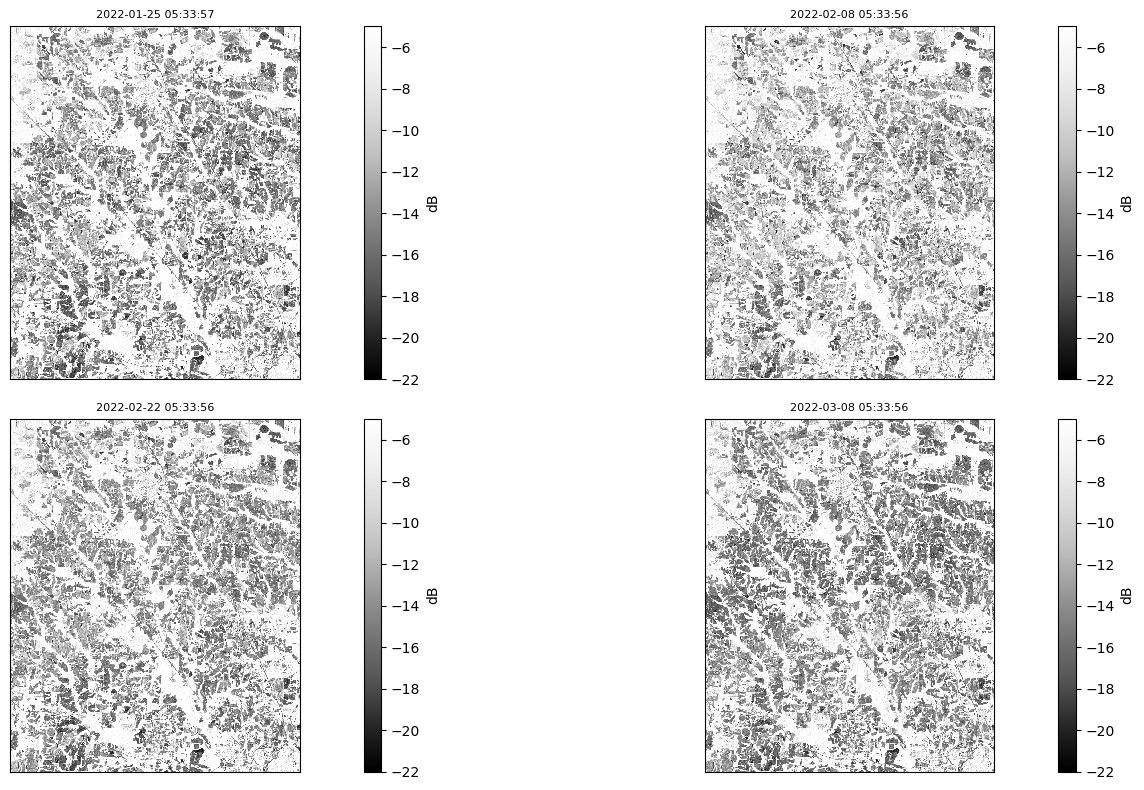

In [13]:
cmp = plt.get_cmap('Greys_r')
plt.rcParams['figure.figsize'] = (20,8)
for i in range(0,min(4,len(a))):
    ax = plt.subplot(2,2,i+1)
    plt.imshow(10*np.log10(a[i,:,:]),vmin = -22,vmax = -5,interpolation ='nearest',cmap = cmp)
    plt.colorbar(label = 'dB')
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])
    plt.title(date_array[i],fontsize=8) 
    plt.tight_layout()
    
print(which_pol)

## 1.6  &emsp; Get geocoding information

In [ ]:
width = ds_x[0].shape[0]
height = ds_y[0].shape[0]
transform = rasterio.Affine(ds_x[0][1] - ds_x[0][0], 0.0, ds_x[0][0] - ((ds_x[0][1] - ds_x[0][0])/2), 0.0, ds_y[0][1] - ds_y[0][0], ds_y[0][0] - ((ds_y[0][1] - ds_y[0][0]) / 2))
crs = rasterio.CRS.from_epsg(ds_epsg[0])
EPSG = ds_epsg[0]
x_posting = transform[0]
y_posting = transform[0]
minx = ds_x[0][0]
miny = ds_y[0][-1]
maxx = ds_x[0][-1]
maxy = ds_y[0][0]

meta = {'driver': 'GTiff', 
        'dtype': 'uint8', 
        'nodata': 0, 
        'width': width, 
        'height': height, 
        'count': 1, 
        'crs': crs, 
        'transform': transform,
        'tiled': True,
        "driver": "COG",
        "compress": "LZW",   # Apply LZW compression
        "blockxsize": 512,   # Tile size
        "blockysize": 512,
        "overviews": [2, 4, 8, 16],  # Pyramid overviews
        "BIGTIFF": "YES",
        'interleave': 'band'}


# Get water mask

## 1.7  &emsp; Radar cross section  watermask generation 


This section generates a watermask from the Radar Cross Section (RCS) values across the observed time series. Water has a high variation measurement not comparable to the CV values of other non-cropland land covers and is often missclassified because of this. Through implementation of a threshold based approach, pixels in the time series stack are classified as water if their RCS value is equal to or below the user-defined threshold more than 75% of the time (across the time series stack), ensuring that the high variation of water remains accounted for to reduce the risk of potential misclassification.  <br>
>**Note:** generation of the RCS watermask will require some investigation of scene statistics as well as visual inspection of the time series stack for adequate selection of a threshold. Water bodies are typically visually notable in SAR imagery, due to the nature for which they interact with the microwave pulses transmitted by the SAR system (i.e. NISAR). Water typically behaves similarly to a mirror when recieving the transmitted pulses, reflecting the energy away from the sensor. Thus, since the recieved pulse is reflected away, very little signal reflects directly back to the sensor, resulting in distinguisably lower backscatter values and a visually darker presence in the image compared to neighboring and surronding land cover.
>> The threshold for distinguising water pixels will vary depending both on the SAR imagery used and the temporal period of the time series stack. A very loose reference RCS reference range for water is -15 dB to -30 dB, with the understanding that the threshold value may end up being outside of this range. 
>

In [ ]:
db_arr = 10 * np.log10(a)

In [ ]:

# Peaks in the RCS histogram can be referenced for selection of the watermask threshold 
print('Values in dB')
print("Pixel Standard Deviation: Min = %s, Max = %s, Mean = %s" %(round(np.nanmin(db_arr),6),round(np.nanmax(db_arr),6),round(np.nanmean(db_arr),6)))

plt.figure(figsize = (9,6))
show_hist(db_arr,bins = 50, title = "Histogram of %s RCS values" %(which_pol))  # this is the only routine that uses rasterio


In [ ]:
# define RCS threshold and reclassify time series based on threshold
water_number = 111
watermask_cmap = plt.cm.colors.ListedColormap(["#ffffff", "#496fa2"])
water_thresh = -16.5
masked_ts_stack = np.where(db_arr <= water_thresh,1,0)

# aggregate the water mask over time, if a pixel is classified as water based on the threshold used at least 75% of the time, 
# it is classified as water across the entire time series stack 
rcs_watermask = (np.sum(masked_ts_stack, axis = 0) > (db_arr.shape[0] * 0.75)).astype(int)

# reclassify the watermask to match the classification values of the CDL (water= 111)
watermask = np.copy(rcs_watermask)
watermask[np.where(rcs_watermask == 1)] = 111

# get the number of pixels masked and not masked
rcs111 = np.count_nonzero(watermask == water_number)
print("Number of water pixels:", rcs111)

rcs0 = np.count_nonzero(watermask == 0)
print("Number of pixels for classification:", rcs0)
    
# visually inspect the watermask, and adjust threshold if needed
fig, ax = plt.subplots(figsize = (5,5))
fig.tight_layout()
cax = ax.imshow(watermask, interpolation ='nearest', cmap = watermask_cmap)
ax.set_title("Water Mask")
cbar = fig.colorbar(cax, ticks = [0,111], fraction = 0.046 * watermask.shape[0] / watermask.shape[1],pad = 0.04)
cbar.ax.set_yticklabels(['Non-Water', 'Water'])
plt.ylabel('Y Coordinates (meters)', labelpad=10)
plt.xlabel('X Coordinates (meters)', labelpad=10)
print('Water pixels are marked as blue')

# 2 &emsp; Coefficient of Variation 

## 2.1 &emsp; Calculating the CV on the SAR Timeseries Stack

The equation for the Coefficient of Variation (CV) is:

CV = Standard Deviation / Mean

In [ ]:
try:
    # Calculate the mean for the time stack of images
    mean = np.mean(a, axis = 0)

    # Calculate the standard deviation for the time stack of images
    std = np.std(a, axis = 0)

    # Calculate the coefficient of variation for the time stack of images 
    CV = (std/mean)#*mask
except ValueError as e:
    print('caculation of CV failed', e)
else:
    print('✅ CV successfully caculated')


In [ ]:
plt.set_cmap('Reds_r')
plt.rcParams['figure.figsize'] = (20,5)
plt.imshow(10*np.log10(mean), vmin = -22, vmax = -10, interpolation ='nearest');
plt.colorbar(fraction = 0.046*mean.shape[0] / mean.shape[1], pad = 0.04);
plt.ylabel('Y Coordinates (meters)', labelpad=10)
plt.xlabel('X Coordinates (meters)', labelpad=10)
plt.title('Mean of Radar-Cross Section(dB)')

## 2.2 &emsp; Plots

In [ ]:
print('Values in dB')
print("Pixel Standard Deviation: Min = %s, Max = %s, Mean = %s" %(round(np.nanmin(std),6),round(np.nanmax(std),6),round(np.nanmean(std),6)))
print("Pixel Coefficient of Variation: Min = %s, Max = %s, Mean = %s" %(round(np.nanmin(CV),6),round(np.nanmax(CV),6),round(np.nanmean(CV),6)))

show_hist(np.clip(CV,0,1),bins = 50,title = "Histogram of %s CV values" %(which_pol))  


In [ ]:
plt.imshow(std, vmin = 0, vmax = 0.02, interpolation = 'nearest', cmap = cmp);
plt.colorbar(fraction = 0.046*std.shape[0]/std.shape[1], pad=0.04);
plt.ylabel('Y Coordinates (meters)', labelpad = 10)
plt.xlabel('X Coordinates (meters)', labelpad = 10)
plt.title('Standard deviation of Radar Cross Section (magnitude)');

In [ ]:
plt.imshow(CV, vmin = 0.05, vmax = 1, interpolation ='nearest', cmap = 'Reds_r');
plt.colorbar(fraction = 0.046*CV.shape[0] / CV.shape[1], pad=0.04);
plt.ylabel('Y Coordinates (meters)', labelpad = 10)
plt.xlabel('X Coordinates (meters)', labelpad = 10)
plt.title('Coefficient of Variation');

In [ ]:
# del std,mean,a

## 2.3&emsp; Export CV and then crop CV to extent of AOI

In [ ]:
today = date.today().strftime("%Y%m%d")
if demo:
    aoi_prefix = 'TFGA'
else: 
    aoi_prefix = input('first four intuitive letters of site name, in uppercase  (i.e. TFGA for Tifton, GA):')

CV_prefix = "NISAR_CV_%s_40_A_CROP_%s_%s_%s_001_%s.tif" %(str(which_pol[:-2]), l3_start_date, l3_end_date, aoi_prefix, today)

try: 
    with rasterio.open(crop_dir / CV_prefix, 'w', **meta) as dst:
        dst.write(CV,indexes = 1)  
        print("✅ Success!")
except Exception as e:
    print('An error occured: {e}')
    


# 3 &emsp; Generate L3 Crop Area Product


## 3.1 &emsp; Define threshold to classify crop area 
**Where:**
>CV pixels >= threshold are classified as "crop" <br>
>CV pixels < threshold are classified as "non-crop" <br>


A pre-calibrated threshold for the example Tifton,GA data set within this repo has been provided.  Here, the ideal threshold was derived by Youden's J-Index, a summary measure representing the maximum difference between the true positive rate and false positive rate between the Coefficient of Variation and the validation source (i.e the CDL). While the ROC curve technique offers a statistical guidance to a threshold with discriminatory ability between crop area and non-crop area, users can also provide their own threshold from a "guess and check" approach. 

In [ ]:
if demo:
    best_thresh = 0.4
    print("Threshold for crop/non-crop classification:", best_thresh)
else:
    best_thresh = input("Threshold for classification?")

##### 

## 3.5 &emsp; Create crop/non-crop classification for the Youden's Index Optimal Threshold

In [ ]:
#Classify image using the Youden's Index Optimal Threshold
CV_reclass_ideal = np.copy(CV)
CV_reclass_ideal[np.where(CV_reclass_ideal >= best_thresh)] = 1
CV_reclass_ideal[np.where(CV_reclass_ideal < best_thresh)] = 0

In [ ]:
# apply watermask to classified result
# first reclassify the watermask, so that all water pixels have a value of 3
watermask0 = copy.deepcopy(watermask)
watermask0[np.where(watermask0 == 111)] = 3
CV_reclass_ideal_w_h20 = np.subtract(CV_reclass_ideal,watermask0)


# reclassify the final classification to reset the waterpixels to a value of 3 again 
CV_reclass_ideal_w_h20[np.where(CV_reclass_ideal_w_h20 == -3)] = 3
CV_reclass_ideal_w_h20[np.where(CV_reclass_ideal_w_h20 == -2)] = 3

### Visually inspect the classification before exporting and downsampling to hectare scale

In [ ]:
fig, ax = plt.subplots(figsize = (20,5))
fig.tight_layout()
l3_cmap = plt.cm.colors.ListedColormap(["#ffffff", "#EDB218", "#496fa2"])
cax = ax.imshow(CV_reclass_ideal_w_h20, interpolation = 'nearest', cmap = l3_cmap)
ax.set_title('Final CV Classification: %s' %(which_pol))
cbar = fig.colorbar(cax, ticks = [0,1,3], fraction = 0.046 * CV_reclass_ideal_w_h20.shape[0] / CV_reclass_ideal_w_h20.shape[1],pad = 0.04)
cbar.ax.set_yticklabels(['Non-Crop', 'Crop', 'Water'])
plt.ylabel('Y Coordinates (meters)', labelpad = 10)
plt.xlabel('X Coordinates (meters)', labelpad = 10)

print('Crop pixels marked in yellow')

## 3.6 &emsp; Export the classified image as 20m, downsample to 1 Ha resolution and export final L3 classification product

Writes the array to a geotiff that is classified by the Youden's Index ideal threshold based on CV to the set output directory. 

In [ ]:

classified_20m_prefix = "%s_%s_%s_20m_classification.tif" %(aoi_prefix, str(which_pol[:-2]), today)
L3_prefix = "NISAR_L3_%s_40_A_CROP_%s_%s_%s_001_%s.tif" %(str(which_pol[:-2]), l3_start_date, l3_end_date, aoi_prefix, today)
print(classified_20m_prefix)
print(L3_prefix)

In [ ]:
# reclassify the classified image to match the proper crop l3 classification values 
# where: non_crop = 1, crop = 2, water =3

l3_CV_reclass_ideal_w_h20= np.copy(CV_reclass_ideal_w_h20)
l3_CV_reclass_ideal_w_h20[CV_reclass_ideal_w_h20 == 0] = 1
l3_CV_reclass_ideal_w_h20[CV_reclass_ideal_w_h20 == 1] = 2
print(np.unique(l3_CV_reclass_ideal_w_h20))

In [ ]:
with rasterio.open(TMP_dir / classified_20m_prefix, 'w', **meta) as dst:
    dst.write(l3_CV_reclass_ideal_w_h20,indexes = 1)  
   
fig, ax = plt.subplots(figsize=(20,5))
fig.tight_layout()
cax = ax.imshow(CV_reclass_ideal_w_h20, interpolation = 'nearest', cmap = l3_cmap)
ax.set_title('Classified Crop/Non-Crop Area (20m resolution) ')
cbar = fig.colorbar(cax, ticks = [0,1,3], fraction = 0.046 * CV_reclass_ideal_w_h20.shape[0] / CV_reclass_ideal_w_h20.shape[1],pad = 0.04)
cbar.ax.set_yticklabels(['Non-Crop', 'Crop', 'Water'])
plt.ylabel('Y Coordinates (meters)', labelpad = 10)
plt.xlabel('X Coordinates (meters)', labelpad = 10)


print('Crop pixels marked in yellow (Non-crop = 1, Crop = 2, Water = 3')


## 3.7 &emsp; Downsample to the hectare scale for generation of the final L3 crop area product 

In [ ]:
classified_20m_files = sorted(glob.glob(str(TMP_dir / classified_20m_prefix)))
for file in classified_20m_files:
    classified_20m_filename = str(file)
    classified_20m_file = gdal.Open(classified_20m_filename)
    print(classified_20m_filename)

try:
    gdal.Warp(str(aoi_dir / L3_prefix), classified_20m_file, xRes = 100, yRes = 100, resampleAlg ='near', format = 'GTIFF')
    #os.remove(str(TMP_dir/classified_20m_filename))
    print("✅ Success!")
except Exception as e:
    print('An error occured: {e}')

In [ ]:
L3_product_file = glob.glob(str(aoi_dir / L3_prefix))
for file in L3_product_file:
    L3_product = str(file)
    croparea_L3_classification = gdal.Open(L3_product).ReadAsArray()

fig, ax = plt.subplots(figsize=(10,10))
fig.tight_layout()
cax = ax.imshow(croparea_L3_classification, interpolation ='nearest', cmap = l3_cmap)
ax.set_title('Classified Crop/Non-Crop Area (1 Ha resolution)')
cbar = fig.colorbar(cax, ticks = [0,1,3], fraction = 0.046*croparea_L3_classification.shape[0] / croparea_L3_classification.shape[1], pad = 0.04)
cbar.ax.set_yticklabels(['Non-Crop', 'Crop', 'Water'])
plt.ylabel('Y Coordinates (meters)', labelpad = 10)
plt.xlabel('X Coordinates (meters)', labelpad = 10)

print('Crop pixels marked in yellow (Non-crop = 1, Crop = 2, Water = 3')


In [ ]:
 ## A statistical summary of the number of Crop and Non-Crop pixels from the crop/non-crop classification 

l3_cropcount = np.count_nonzero(croparea_L3_classification == 2)
l3_noncount = np.count_nonzero(croparea_L3_classification == 1)
l3_watercount = np.count_nonzero(croparea_L3_classification == 3)
l3_nodata_count = np.count_nonzero(croparea_L3_classification == 0)

total = np.count_nonzero(croparea_L3_classification != 0)

# finding the percent of pixels classified as crop area, non-crop area and water
percent_l3_crop = round((l3_cropcount / total) * 100,2)
print('% Crop',percent_l3_crop)
percent_l3_noncrop = round((l3_noncount / total) * 100, 2)
print('% Non-Crop',percent_l3_noncrop)
percent_l3_water = round((l3_watercount/total) * 100,2)
print('% Water', percent_l3_water)
percent_l3_nodata = round((l3_nodata_count/total) * 100,2)
print('% No Data', percent_l3_nodata)


### **set up metadata parameters**

In [ ]:
sar_array = []
for ii in indices2:
    fp = all_GCOV_data[ii].split('/')[-1]
    sar_array.append(fp)


In [ ]:
first_nisar_date = str(sar_array[0])
last_nisar_date = str(sar_array[-1])

source_collectiontime_last = re.findall(r"\d{8}T\d{6}", last_nisar_date)
source_collectiontime_first = re.findall(r"\d{8}T\d{6}", first_nisar_date)

print(source_collectiontime_last)
print(source_collectiontime_first)

In [ ]:
# define L3 color table (DN values mapped to RGB colors) 
color_table_1ha = {
#no data
    0: (255, 255, 255, 0),
#non-crop
    1: (255, 255, 255, 1),
#crop
    2: (237, 178, 24, 1),
#wateer 
    3: (73, 111, 162, 1)
    

}
    
with rasterio.open(aoi_dir / L3_prefix, 'w', **meta) as dst:
    dst.write(croparea_L3_classification,indexes=1)  
    dst.write_colormap(1, color_table_1ha)
    dst.colorinterp = [ColorInterp.palette]
    # Create overviews (pyramids) for faster cloud visualization
    overviews = [2, 4, 8, 16]  # Example downsampling levels
    dst.build_overviews(overviews, Resampling.average)
    # Update metadata
    dst.update_tags(
        AREA_OR_POINT = "Area",
        CEOS_docid ='https://ceos.org/ard/files/PFS/SAR/v1.1/CEOS-ARD_PFS_Synthetic_Aperture_Radar_v1.1.pdf',
        prod_name = 'CROP',
        prod_processing_date = datetime.now(UTC).strftime("%Y%m%dT%H%M%S"),
        prod_software_version = "1.0",
        prod_speckle_filter = "FALSE",
        prod_type =" SCIENCE ",
        source_band_width = "20",
        source_center_wavelength = "0.238403545 m",
        source_collectiontime_last = source_collectiontime_last,
        source_collectiontime_first = source_collectiontime_first,
        source_data_access = "ASF NASA/JAXA agreement",
        source_instrument = "L-SAR",
        source_number_of_acquisitions = time_series_length,
        source_pointing = "left",
        source_pol = which_pol,
        source_radar_az_looks = "22",
        source_radar_range_looks = "5",
        source_radar_band = "L",
        source_radar_east_pixel_spacing = "20",
        source_radar_look_look_direction = "Ascending",
        source_radar_mode = "polsar",
        source_radar_nes0 = "-30",
        source_radar_north_pixel_spacing = "100",
        source_radar_pointing = "left",
        source_radar_pol = "quad",
        source_radar_processing_facility = "NASA Jet Propulsion Laboratory",
        source_radar_product_level = "L2",
        source_radar_software_version = '83634531328a6b1fb3991f252a5c6d52b7a9ed4b',
        source_satellite = 'NISAR',
        stats_percDN0 = l3_nodata_count,
        stats_percDN1 = l3_noncount,
        stats_percDN2 = l3_cropcount,
        stats_percDN3 = l3_watercount,
        Classes = "Described Below",
        DN3 = "Water",
        DN2 = "Active Crop",
        DN1 = "Non-Crop",
        DN0 = "No Data   (transparent)   ",
    )
        

# Optional: validation & accuracy assesment 
What follows below, demonstrates the validation and accuracy assesment process implemented to evaulate whether the produced crop area classification meets the NISAR L2 science requirement for active crop area. 

## Define validation/training data source

In [ ]:
training_data_type = input('"CDL" or "EXTERNAL SOURCE":')

# 4 &emsp; Validation Data Preparation

>**Note:** The data provided as part of this NISAR ATBD notebook for TIfton, GA includes a pre-downloaded, cropped and aligned Cropland Data Layer for which the notebook can be self-contained without any additional downloading or importing of other validation resources required. However, option for use of external validation data and functionality to download the CDL are also provided for circumstances where another area of interest is desired to be investigated. 

## 4.1 &emsp; Download the Cropland Data Layer

Having access to the Cropland Data Layer ([CDL](https://nassgeodata.gmu.edu/CropScape/); a landcover classification for the continental US) is not required for the Coefficient of Variation algorithm, it can be used as an input to determine the location of crops versus non-crops, and hence used to determine the best threshold for the NISAR Active Crop Area algorithm.  In locations where the CDL is not available, other products may be available (such as ESA's [GlobCover](http://due.esrin.esa.int/page_globcover.php) and [High Resolution Ground Cover](https://climate.esa.int/en/projects/high-resolution-land-cover/)), or derived independently from available high-resolution optical data.


In [ ]:
if training_data_type == 'CDL':
    cdl_cmap = np.loadtxt(ancillary_dir / 'cdl_cmap.txt',dtype='float')
    cdl_cmap = ListedColormap(cdl_cmap)

    cdl_year = 2023
    cdl_dir = ancillary_dir / 'cdl'
    cdl_full_file = '%s_30m_cdls' %(cdl_year)
    cdl_crop_file = '%s_CDL_%s.tif' %(aoi, cdl_year)  

    if os.path.isfile(crop_dir/cdl_crop_file):
         print(' %s cdl for %s exists already' %(cdl_year, aoi))

    else: 
        if os.path.isfile(cdl_dir/ (cdl_full_file +'.tif'))==False:
            if os.path.isfile(cdl_dir / (cdl_full_file + '.zip'))==False:
                url = 'https://www.nass.usda.gov/Research_and_Science/Cropland/Release/datasets/%s.zip' %(cdl_full_file)
                !wget -P {cdl_dir} -q {'https://www.nass.usda.gov/Research_and_Science/Cropland/Release/datasets/%s.zip'%(cdl_full_file)}
            with zipfile.ZipFile(cdl_dir / (cdl_full_file + '.zip'), 'r') as zip_ref:
                zip_ref.extractall(cdl_dir)
                os.remove(cdl_dir/ (cdl_full_file + '.zip'))
        else:
            print('%s CDL is already downloaded in: %s' %(cdl_year, cdl_dir))

        CDL_full = glob.glob(str(cdl_dir / (cdl_full_file + '.tif')))[0]
else:
     print('%s is specified as the training/validation source' %(training_data_type))

> **Note:** The native spatial resolution of the Cropland Data Layer (from 2008-2023) is 30m. For the 2024 CDL, this has increased to 10m. In order to harmonize the use of the CDL with SAR data, consistent spatial resolution and grid alignment is fundamental for acheiving accurate classification results. The cell below implements the gdalwarp tool to both crop the CDL to the extent of the Area of Interest and resample the data to match the spatial resolution of the SAR time series stack (20m). The CDL is clipped to the extent of the AOI by the *-te* flag, which uses the bounding box extent defined by the AOI geojson file above, while the *-tap* flag (target aligned pixels) ensures the the output grid is properly aligned with the reference SAR image. The *-tr* flag resamples the spatial resolution of the CDL, by setting the target pixel size. In this case, this is defined by the predefined x and y positing (20m).<br>
>> Further information about gdal-warp can be found by following the provided link below, which leads to gdal's documentation page: <br>
https://gdal.org/en/stable/programs/gdalwarp.html

In [ ]:
if training_data_type == 'CDL':
    if os.path.isfile(crop_dir/cdl_crop_file):
        print('cdl has already been extracted to extent of %s, skip to cell below' %(aoi)) 
    else: 
        os.system('gdalwarp -overwrite -s_srs epsg:5070 -t_srs epsg:%s -tap -tr %s %s -te %s %s %s %s %s %s' 
                  %(EPSG,transform[0],transform[0],ds_x[0][0],ds_y[0][-1],ds_x[0][-1],ds_y[0][0],CDL_full,crop_dir/cdl_crop_file))
else:
    print('%s is specified as the training/validation source' %(training_data_type))        

In [ ]:
# Get dimensions of CDL
if training_data_type == 'CDL':
    first_raster_CDL = gdal.Open(str(crop_dir/cdl_crop_file))
    rows1 = first_raster_CDL.RasterYSize
    cols1 = first_raster_CDL.RasterXSize


    # Open CDL
    cdl_raster = first_raster_CDL.ReadAsArray()#*mask
    cdl_raster =  cdl_raster.astype(np.float32)
    cdl_raster.astype(np.float32)
    print(cdl_raster.shape)

    CDL_geotransform = first_raster_CDL.GetGeoTransform()
    CDL_xres = CDL_geotransform[1]
    CDL_yres = -CDL_geotransform[5]
    CDL_xmin = CDL_geotransform[0]
    CDL_ymax = CDL_geotransform[3]
    CDL_spatialref = first_raster_CDL.GetProjectionRef()

    plt.rcParams['figure.figsize'] = (20,5);
    plt.imshow(cdl_raster,cmap=cdl_cmap,interpolation='nearest');
    plt.colorbar(fraction=0.046*cdl_raster.shape[0]/cdl_raster.shape[1],pad=0.04);
    plt.ylabel('Y Coordinates (meters)', labelpad=10)
    plt.xlabel('X Coordinates (meters)', labelpad=10)
    plt.title('Cropland Data Layer');

    del first_raster_CDL

    ##The image might look a little busy because of the number of classes in the layer
else:
    print('%s is specified as the training/validation source' %(training_data_type))

## 4.2 &emsp; Identifying Crop pixels in the CDL

Creating a binary crop/non-crop classification from the CDL classified classes.

Crop classified to 1

Non-crop classified to 0

This can be customized by study area and what land use types are present there. 
To make a land class classified as non-crop simply place a "#" infront of the line of code for that land cover.

In the code that follows, these are assigned one-by-one according the to various index indicators that are part of the CDL.


In [ ]:
if training_data_type == 'CDL':
    CDL_crop = np.copy(cdl_raster)
    unique = np.unique(cdl_raster)
    uniquecount = len(unique)

    # Get Crop names and ids
    # Column 0 = Crop ID
    # Column 1 = Crop Name
    # Column 2 = Classification number (1 = crop 0 = not crop)

    crop_ids = pd.read_csv(ancillary_dir / 'crop_ids.csv',header = None)
    # Set all crop classification values equal to 1 
    for i in tqdm(crop_ids[0]):
        CDL_crop[np.where(cdl_raster == i)] = crop_ids[crop_ids[0] == i][2]
    tqdm.write("✅ Success!")
else:
    print('%s is specified as the training/validation source' %(training_data_type))

## 4.3 &emsp; Image of the Crop/Non-Crop classification based on the CDL
Below is the resulting clasification image of Crop versus Non-Crop based on the input Cropland Data Layer

In [ ]:
# Set all non-crop values to 0 based on assumming that everything not previously classified as crop is non-crop
if training_data_type == 'CDL':
    crop_binary = np.copy(CDL_crop)
    crop_binary[np.where(CDL_crop!= 1)] = 0

    fig, ax= plt.subplots(figsize=(20,5))
    fig.tight_layout()
    binary_cmap = plt.cm.colors.ListedColormap(["#ffffff", "#EDB218"])
    cax = ax.imshow(crop_binary, interpolation='nearest', cmap=binary_cmap)
    ax.set_title("Crop/Non Crop Classification based on CDL")
    cbar = fig.colorbar(cax, ticks = [0,1], fraction = 0.046 * crop_binary.shape[0] / crop_binary.shape[1], pad = 0.04)
    cbar.ax.set_yticklabels(['Non-Crop', 'Crop'])
    plt.ylabel('Y Coordinates (meters)', labelpad = 10)
    plt.xlabel('X Coordinates (meters)', labelpad = 10)
    print('Crop pixels marked as white (value of 1.0)')
else:
    print('%s is specified as the training/validation source' %(training_data_type))

In [ ]:
if training_data_type == 'CDL':
    #getting the number of pixels classified as crop and non-crop including the removal of masked pixels
    cropcount = np.count_nonzero(crop_binary == 1)
    print("Number of crop pixels:", cropcount)

    noncount = np.count_nonzero(crop_binary == 0)- rcs111
    print("Number of non-crop pixels:",noncount)

    #finding the percent of pixels classified as crop and non-crop including the removal of masked pixels
    percent_crop_nonmasked_calc = round((cropcount / rcs0) * 100, 2)
    print ("% Crop: ", percent_crop_nonmasked_calc)

    percent_noncrop_nonmasked_calc = round((noncount / rcs0) * 100, 2)
    print ("% Non-crop: ", percent_noncrop_nonmasked_calc)
else:
    print('%s is specified as the training/validation source' %(training_data_type))

## 4.5 &emsp; Import external validation data

In cases where the CDL is not avaliable and / or the an external validation data source is perferred, the user can upload the data here. 
> **Note:** The external validation data should ideally take form of crop/non-crop polygons as a geojson file, where crop polygons are assigned a value of 1, non-crop polygons a value of 0.

In [ ]:
if training_data_type == 'EXTERNAL SOURCE':
    file = input("provide full filepath of crop/non-crop geojson file:")
    filename = (file.split('/')[-1])
else:
     print('%s is specified as the training/validation source' %(training_data_type))

In [ ]:

if training_data_type == 'EXTERNAL SOURCE':
    file = input("provide full filepath of crop/non-crop geojson file:")
    filename= (file.split('/')[-1])

    try:
        rasterized2 = gdal.Rasterize(crop_dir/filename.replace('geojson','tif'), file, format = 'GTIFF',  creationOptions = ["COMPRESS=DEFLATE"], 
                                     noData = 2, xRes=20, outputType = gdal.GDT_Int16,
                                     yRes = 20,allTouched=False,attribute ='id')


        rasterized2 = None
        tqdm.write('✅ Validation polygons sucessfully rasterized ')
        
    except Exception as e:
        print('An error occured: {e}')
else:
     print('%s is specified as the training/validation source' %(training_data_type))

### Tap the rasterized training polygons to ensure extent and pixel alignment with the CV

In [ ]:
if training_data_type == 'EXTERNAL SOURCE':

    updated_fn= str(crop_dir/filename.replace('geojson','tif'))
    updated_fn2= str(updated_fn[:-4]+'_corr.tif')
    os.system('gdalwarp -overwrite -srcnodata 2 -dstnodata 2 -tap -tr %s %s -te %s %s %s %s %s %s' 
              %(transform[0], transform[0], ds_x[0][0],ds_y[0][-1],ds_x[0][-1],ds_y[0][0],updated_fn,crop_dir/updated_fn2))

else:
    print('%s is specified as the training/validation source' %(training_data_type))                            

In [ ]:
if training_data_type == 'EXTERNAL SOURCE':
    crop_binary= gdal.Open(crop_dir/updated_fn2).ReadAsArray()
    print(crop_binary.shape)
     # clean up un-tapped files (tifs) 
    os.system('rm -r %s'%(updated_fn))

    plt.rcParams['figure.figsize'] = (8,16)
    plt.imshow(crop_binary,vmin=0,vmax=2,cmap='viridis');
    # 2 is background, 0 is non-crop, 1 is crop
    plt.colorbar(ticks = [0, 1, 2],fraction=0.045*crop_binary.shape[0]/crop_binary.shape[1],pad=0.04);
    plt.title('Crop/non-crop polygons (Validation): 0 non-crop, 1 crop, 2 background')
    
else:
    print('%s is specified as the training/validation source' %(training_data_type))                            

## 4.6 &emsp; A statistical summary of the number of Crop and Non-crop polygons form external validation data

finding the breakdown of crop/non-crop pixels 

In [ ]:
if training_data_type == 'EXTERNAL SOURCE':
    cropcount_val = np.count_nonzero(crop_binary == 1)
    print("Number of crop pixels:", cropcount_val)

    noncount_val= np.count_nonzero(crop_binary == 0)
    print("Number of non-crop pixels:", noncount_val)

    # Percent of pixels classified as crop and non_crop based on Polygons (Validation)

    pol0_val = cropcount_val + noncount_val

    percent_crop_val = round((cropcount_val / pol0_val)*100, 2)
    print(" % Crop:", percent_crop_val)

    percent_noncrop_val = round((noncount_val / pol0_val)*100, 2)
    print("% Non-Crop:", percent_noncrop_val)
else:
     print('%s is specified as the training/validation source' %(training_data_type))

## 5 &emsp; Getting Accuracy Statistics for the Youden's Index Optimal Threshold

##### Objectives: 
1. Create a crop/non-crop classification based on the Youden's Index optimal threshold (section 2.1) 
2. Return the J-statistic for the determined threshold (maximum difference value between TPR and FPR ranging between 0 and 1)
3. Get percent crop and non-crop classified correctly and incorrectly
4. Get User's and Producer's accuracy of the classification for both crop and non-crop classes
5. Calculate the Kapppa Coefficient = the measure of the agreement between the SAR imagery derived classification and the CDL
   - Kappa = (total pixel x total correct pixel - sum of the products)/(total pixel^2 - sum of products)
   - Sum of products = sum of row total x column total
   - Interpreting Kappa Statistic:
       - < 0.20 = Poor agreement 
       - 0.20 - 0.40     = Fair agreement 
       - 0.40 - 0.60     = Moderate agreement 
       -  0.60 - 0.80     = Good agreement 
       - 0.80 - 1.00     = Very good agreement

Objectives: 
1. Create a crop/non-crop classification based on the Youden's Index optimal threshold (section 2.1) 
2. Return the J-statistic for the determined threshold (maximum difference value between TPR and FPR ranging between 0 and 1)
3. Get percent crop and non-crop classified correctly and incorrectly
4. Get User's and Producer's accuracy of the classification for both crop and non-crop classes
5. Calculate the Kapppa Coefficient = the measure of the agreement between the SAR imagery derived classification and the CDL
   - Kappa = (total pixel x total correct pixel - sum of the products)/(total pixel^2 - sum of products)
   - Sum of products = sum of row total x column total
   - Interpreting Kappa Statistic:
       - < 0.20 = Poor agreement 
       - 0.20 - 0.40     = Fair agreement 
       - 0.40 - 0.60     = Moderate agreement 
       -  0.60 - 0.80     = Good agreement 
       - 0.80 - 1.00     = Very good agreement

### Read in true positive and false positive arrays 

In [ ]:
try:
    TPR_FPR_arrs = np.load(str(TMP_dir/'TPR_FPR_arrs.npz'))
    tpr = TPR_FPR_arrs['TPR']
    fpr = TPR_FPR_arrs['FPR']
    tqdm.write('✅ Success!')
except Exception as e:
    print('An error occured: {e}')

In [ ]:
thresholds= list(np.linspace(0,99,100)/100)

In [ ]:
# Classify image using the Youden's Index Optimal Threshold
try: 
    CVideal_water = np.subtract(CV_reclass_ideal, watermask)
    CVideal_crop_non = np.copy(CVideal_water)
    CVideal_crop_non[np.where(CVideal_crop_non > 0)] = 1
    CVideal_crop_non[np.where(CVideal_crop_non <= 0)] = -10
    CV_ideal = np.subtract(crop_binary, CVideal_crop_non)
    tqdm.write('✅ Success!')
except Exception as e:
    print(f"An error occured: {e}")

# Determining the J-statistic calculated by finding the maximum difference between the TPR and FPR
j_scores = tpr-fpr
j_ordered = sorted(zip(j_scores,thresholds))
j_statistic = (np.round(j_ordered[-1][0], 2))

In [ ]:
print('statistics of accuracy of using CV to classify crop vs non crop based on', training_data_type)
if training_data_type == "CDL":
    
    p_crop_correct = np.count_nonzero(CV_ideal == 0)/(rcs0)
    p_crop_correct1 = (round((p_crop_correct*100), 2))
    print ('% correct crop: ',p_crop_correct1)
    p_non_correct = (np.count_nonzero(CV_ideal == 10) - rcs111)/(rcs0)
    p_non_correct = (np.count_nonzero(CV_ideal == 10))/(rcs0)
    p_non_correct1 = (round((p_non_correct)*100, 2))
    print ('% correct non-crop: ', p_non_correct1)
    p_crop_incorrect = np.count_nonzero(CV_ideal == 11)/(rcs0)
    p_crop_incorrect1 = (round((p_crop_incorrect)*100, 2))  
    print ('% incorrect crop: ', p_crop_incorrect1)
    p_non_incorrect = np.count_nonzero(CV_ideal == -1)/(rcs0)
    p_non_incorrect1 = (round((p_non_incorrect)*100, 2))    
    print ('% incorrect non-crop: ', p_non_incorrect1)

if training_data_type == "EXTERNAL SOURCE":
    p_crop_correct = np.count_nonzero(CV_ideal == 0)/(pol0_val)
    p_crop_correct1 = (round((p_crop_correct*100),2))
    print ('% correct crop: ',p_crop_correct1)
    p_non_correct = (np.count_nonzero(CV_ideal == 10)) /(pol0_val)
    p_non_correct = (np.count_nonzero(CV_ideal == 10))/(pol0_val)
    p_non_correct1 = (round((p_non_correct)*100, 2))
    print ('% correct non-crop: ', p_non_correct1)
    p_crop_incorrect = np.count_nonzero(CV_ideal == 11)/(pol0_val)
    p_crop_incorrect1 = (round((p_crop_incorrect)*100, 2))  
    print ('% incorrect crop: ', p_crop_incorrect1)
    p_non_incorrect = np.count_nonzero(CV_ideal == -1)/(pol0_val)
    p_non_incorrect1 = (round((p_non_incorrect)*100, 2))    
    print ('% incorrect non-crop: ', p_non_incorrect1)

# Getting Overall Accuracy statistics of the CV classification using Youden's Index optimal threshold based on classification from training data type
print ('\nStatistics of overall accuracy of using CV to classify crop vs non-crop based on', training_data_type)
p_overall_correct = round((p_crop_correct + p_non_correct)*100, 2)
print ('% overall correct: ', p_overall_correct)
p_overall_incorrect = round((p_crop_incorrect + p_non_incorrect)*100, 2)
print ('% overall incorrect: ', p_overall_incorrect)

# Getting user's and producer's accuracy of the CV classification based on CDL classifications
print ('\nUsers and producers accuracy statistics:')
crop_correct = np.count_nonzero(CV_ideal == 0)
non_correct = np.count_nonzero(CV_ideal == 10)
crop_incorrect = np.count_nonzero(CV_ideal == 11)
non_incorrect = np.count_nonzero(CV_ideal == -1)

crop_producers_total = crop_correct + crop_incorrect
crop_users_total = crop_correct + non_incorrect

if training_data_type == "CDL":
    non_producers_total = (non_correct - rcs111) + non_incorrect
    non_users_total = (non_correct - rcs111) + crop_incorrect
    crop_p_accuracy = round((crop_correct/crop_producers_total)*100, 2)
    print ('% crop producers accuracy: ', crop_p_accuracy)
    non_p_accuracy = round(((non_correct - rcs111)/non_producers_total)*100, 2)
    print('% non-crop producers accuracy: ', non_p_accuracy)
    crop_u_accuracy = round((crop_correct/crop_users_total)*100, 2)
    print ('% crop users accuracy: ', crop_u_accuracy)
    non_u_accuracy = round(((non_correct - rcs111)/non_users_total)*100, 2)
    print ('% non-crop users accuracy: ', non_u_accuracy)

if training_data_type == "EXTERNAL SOURCE": 
    non_producers_total= non_correct + non_incorrect
    non_users_total= non_correct + crop_incorrect
    crop_p_accuracy= round((crop_correct/crop_producers_total)*100,2)
    print ('% crop producers accuracy: ', crop_p_accuracy)
    non_p_accuracy= round((non_correct/non_producers_total)*100,2)
    print('% non-crop producers accuracy:', non_p_accuracy)
    crop_u_accuracy= round((crop_correct/crop_users_total)*100,2)
    print('% crop users accuracy:', crop_u_accuracy)
    non_u_accuracy= round((non_correct/non_users_total)*100,2)
    print('% non-crop users accuracy:', non_u_accuracy)

# calcuating Kappa Coefficient

if training_data_type == "CDL":
    Total_correct = np.count_nonzero(CV_ideal == 0) + (np.count_nonzero(CV_ideal == 10) - rcs111)
    Total_pixel_count = (rcs0)
    Sum_of_products_crop_row = np.count_nonzero(CV_ideal == 0) + np.count_nonzero(CV_ideal == -1)
    Sum_of_products_non_row = (np.count_nonzero(CV_ideal == 10) - rcs111) + np.count_nonzero(CV_ideal == 11)
    Sum_of_products_crop_col = np.count_nonzero(CV_ideal == 0) + np.count_nonzero(CV_ideal == 11)
    Sum_of_products_non_col = (np.count_nonzero(CV_ideal == 10) - rcs111) + np.count_nonzero(CV_ideal == -1)

if training_data_type == "EXTERNAL SOURCE":
    Total_pixel_count= (pol0_val)
    Total_correct = np.count_nonzero(CV_ideal== 0) + (np.count_nonzero(CV_ideal == 10))
    sum_of_products_crop_row = np.count_nonzero(CV_ideal == 0) + np.count_nonzero(CV_ideal == -1)
    Sum_of_products_non_row = (np.count_nonzero(CV_ideal == 10)) + np.count_nonzero(CV_ideal== 11)
    Sum_of_products_crop_col = np.count_nonzero(CV_ideal == 0) + np.count_nonzero(CV_ideal == 11)
    Sum_of_products_non_col = (np.count_nonzero(CV_ideal == 10)) + np.count_nonzero(CV_ideal == -1)

Sum_of_products = (Sum_of_products_crop_row * Sum_of_products_crop_col) + (Sum_of_products_non_row * Sum_of_products_non_col)

Kappa_coefficient = round((Total_pixel_count * Total_correct - Sum_of_products) / (Total_pixel_count * Total_pixel_count - Sum_of_products), 2)
print ('\nKappa Coefficient: ', Kappa_coefficient)
if Kappa_coefficient <= 0.2:
    print ('Poor agreement')
else:
    if Kappa_coefficient <= 0.4:
        print ('Fair agreement')
    else:
        if Kappa_coefficient <= 0.6:
            print ('Moderate agreement')
        else: 
            if Kappa_coefficient <= 0.8:
                print ('Good agreement')
            else: 
                if Kappa_coefficient > 0.8:
                    print ('Very good agreement')

##  &emsp; Export Accuracy Results

Writes the calculated accuracy results to an excel CSV file to the set output directory. 

In [ ]:
Accuracy_results = "NISAR_L3_%s_40_A_CROP_%s_%s_%s_001_%s_accuracy_statistics.csv" %(str(which_pol[:-2]), l3_start_date, l3_end_date, aoi_prefix, today)


In [ ]:
#Exporting accuracy statistics as a CSV file

l0 = [best_thresh]
l1 = [p_overall_correct]
l2 = [p_crop_correct1]
l3 = [p_non_correct1]
l4 = [p_crop_incorrect1]
l5 = [p_non_incorrect1]
l6 = [crop_p_accuracy]
l7 = [non_p_accuracy]
l8 = [crop_u_accuracy]
l9 = [non_u_accuracy]
l10 = [Kappa_coefficient]
l11 = [j_statistic]


df = pd.DataFrame({"Threshold": l0, "Overall Correct": l1, "% crop correct": l2, "% non-crop correct": l3, "% crop incorrect": l4, "% non-crop incorrect": l5, "% Crop Producers Accuracy": l6, "% Non-crop Producers Accuarcy": l7, "% Crop Users Accuracy":l8, "% Non-crop Users Accuracy": l9, "Kappa Coefficient": l10, "J-statistic": l11})

df.to_csv(str(aoi_dir / Accuracy_results))

df

<a id="SEC_6"></a>
# 6 &emsp; References

1.	Whelen, T. and P. Siqueira, “A Multi-season Study of L-band UAVSAR Observations for Agricultural Fields in the San Joaquin Valley,” Rem. Sens. Env., 193, 216-224, https://doi.org/10.1016/j.rse.2017.03.014, 2017.

2.	Whelen, T. and P. Siqueira, “Time-series agricultural classification of Sentinel-1 data over North Dakota,” Rem. Sens. Lett., 9(5), 411-420, https://doi.org/10.1080/2150704X.2018.1430393, 2018.

3.	Whelen, T. and P. Siqueira, “Coefficient of variation for use in crop area classification across multiple climates,” Int. J. Appl. Earth. Obs. & Geoinf., 67, 114-122, https://doi.org/10.1016/j.jag.2017.12.014, 2018.

4.	Kraatz, S., N. Torbick, X. Jiao, X. Huang, L.D. Robertson, A. Davidson, H. McNairn, M.H. Cosh, P. Siqueira, “Comparison between Dense L-Band and C-Band Synthetic Aperture Radar (SAR) Time Series for Crop Area Mapping over a NISAR Calibration-Validation Site,” Agronomy. 11(2), https://doi.org/10.3390/agronomy11020273, 2021.

5.	Kraatz, S., S. Rose, M. Cosh, N. Torbick, X. Huang, & P. Siqueira, “Performance evaluation of UAVSAR and simulated NISAR data for crop/noncrop classification over Stoneville, MS.” Earth and Space Sci, 8(1), e2020EA001363. https://doi.org/10.1029/2020EA001363, 2021

6.	Rose, S., S. Kraatz, J. Kellndorfer, M.H. Cosh, N. Torbick, X. Huang, and P. Siqueira, “Evaluating NISAR's cropland mapping algorithm over the conterminous United States using Sentinel-1 data,” Rem. Sens. Env., 260, 112472, https://doi.org/10.1016/j.rse.2021.112472, 2021